# Experiment 2-1: Binary Logistic Regression on Iris Dataset

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

from data import Datafile, load_data
from influence.emp_risk_optimizer import EmpiricalRiskOptimizer
from influence.plot_utils import compare_with_loo
from influence.closed_forms import I_loss_RidgeCf
from models.regularized_regression import RegularizedRegression
from models.hyperplane_clf import BinaryLogisticRegression
#from models.hyperplane_clf import SmoothedSupportVector

/Users/zed/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
X_train, X_test, y_train, y_test, test_indices = load_data(
    Datafile.Iris, test_config=0.2)
n_tr, p = X_train.shape
n_te, _ = X_test.shape
print(n_tr, p)

init_eta = 1e-1
batch_size = 30
train_iter = 50000
traceback_checkpoint = 45000
loo_extra_iter = 5000
decay_epochs = (10000, 20000)
checkpoint_iter = traceback_checkpoint-1
iter_to_switch_off_minibatch=35000
iter_to_switch_to_sgd=np.inf
# LOO a on random set of training indices, otherwise too slow
leave_indices = None

if hasattr(test_indices, '__iter__') and hasattr(leave_indices, '__iter__'):
    assert not set(test_indices) & set(leave_indices)
    print(test_indices)
    print(leave_indices)

X_train shape: (80, 4)
y_train shape: (80, 1)
X_test shape: (20, 4)
y_test shape: (20, 1)
80 4


## Fit Model

In [4]:
model = BinaryLogisticRegression(
    model_name='BinaryLogistic-Notebook',
    init_eta=init_eta,
    decay_epochs=decay_epochs,
    batch_size=batch_size,
    C=1.0
)

In [5]:
tf.reset_default_graph()
model = BinaryLogisticRegression(
    model_name='BinaryLogistic-Notebook',
    init_eta=init_eta,
    decay_epochs=decay_epochs,
    batch_size=batch_size,
    C=1.0
)

model.fit(
    X_train, y_train,
    n_iter=train_iter,
    verbose=1,
    iter_to_switch_off_minibatch=iter_to_switch_off_minibatch,
    iter_to_switch_to_sgd=iter_to_switch_to_sgd,
    traceback_checkpoint=traceback_checkpoint
)

Step 0, Epoch 0: loss = 9.09320068 (0.080 sec)
Step 1000, Epoch 375: loss = 0.36808911 (0.001 sec)
Step 2000, Epoch 750: loss = 0.40523782 (0.001 sec)
Step 3000, Epoch 1125: loss = 0.36872992 (0.001 sec)
Step 4000, Epoch 1500: loss = 0.37586689 (0.001 sec)
Step 5000, Epoch 1875: loss = 0.44923431 (0.001 sec)
Step 6000, Epoch 2250: loss = 0.36707470 (0.001 sec)
Step 7000, Epoch 2625: loss = 0.39337766 (0.001 sec)
Step 8000, Epoch 3000: loss = 0.40005186 (0.001 sec)
Step 9000, Epoch 3375: loss = 0.37598175 (0.001 sec)
Step 10000, Epoch 3750: loss = 0.42196387 (0.001 sec)
Step 11000, Epoch 4125: loss = 0.40718022 (0.001 sec)
Step 12000, Epoch 4500: loss = 0.43252799 (0.001 sec)
Step 13000, Epoch 4875: loss = 0.39587021 (0.001 sec)
Step 14000, Epoch 5250: loss = 0.40393561 (0.001 sec)
Step 15000, Epoch 5625: loss = 0.44740659 (0.001 sec)
Step 16000, Epoch 6000: loss = 0.38235670 (0.001 sec)
Step 17000, Epoch 6375: loss = 0.38731194 (0.001 sec)
Step 18000, Epoch 6750: loss = 0.43006524 (0.0

BinaryLogistic-Notebook(init_eta=0.1,batch_size=30,decay_epochs=(10000, 20000),C=1.0)

## Fit with Skearn

In [6]:
tf.reset_default_graph()
model.fit_with_sklearn({'X':X_train, 'y':y_train})


Model Evaluations:
------------------------------------------
Empirical Risk: 0.422830
Norm of Params: 4.106604
Norm of Gradient: 0.051333


BinaryLogistic-Notebook(init_eta=0.1,batch_size=30,decay_epochs=(10000, 20000),C=1.0)

In [7]:
model.get_eval(items=['params_flat'])

array([[ 1.5956767],
       [ 1.8466895],
       [-2.3730352],
       [-2.2970529]], dtype=float32)

## Predicitons (Not Important)

In [8]:
y_pred = model.predict(X_train)
print("Train accuracy:", np.sum(y_pred == y_train)/n_tr)

y_pred_test = model.predict(X_test)
print("Test accuracy:", np.sum(y_pred_test == y_test)/n_te)

Train accuracy: 0.9875
Test accuracy: 0.85


## Calculate I_loss

In [9]:
I_loss_bf = model.influence_loss(
    X_test, y_test,
    method='brute-force',
)
# I_loss_bf[leave_indices,:]/n_tr

Fetch training loss gradients (0.102 sec)


In [10]:
I_loss_cg = model.influence_loss(
    X_test, y_test,
    method='cg',
    tol=1e-7, 
    max_iter=1000
)

Fetch training loss gradients (0.036 sec)
         Current function value: -0.956071
         Iterations: 6
         Function evaluations: 20
         Gradient evaluations: 25
         Hessian evaluations: 17
         Current function value: -0.107540
         Iterations: 5
         Function evaluations: 98
         Gradient evaluations: 93
         Hessian evaluations: 13
         Current function value: -0.120165
         Iterations: 4
         Function evaluations: 65
         Gradient evaluations: 58
         Hessian evaluations: 13
         Current function value: -0.074743
         Iterations: 5
         Function evaluations: 93
         Gradient evaluations: 87
         Hessian evaluations: 15
Optimization terminated successfully.
         Current function value: -0.227125
         Iterations: 6
         Function evaluations: 35
         Gradient evaluations: 40
         Hessian evaluations: 17
         Current function value: -0.254381
         Iterations: 4
         Function e

## Run LOO

In [11]:
loo_diff = model.leave_one_out_refit(
    X_test, y_test,
    n_iter=loo_extra_iter,
    iter_to_load=checkpoint_iter,
    leave_indices=leave_indices,
    sklearn_refit=True
)

LOO Fold 0: loss = 0.42400235 (0.018 sec)
LOO Fold 8: loss = 0.41924122 (0.007 sec)
LOO Fold 16: loss = 0.42120889 (0.003 sec)
LOO Fold 24: loss = 0.41813612 (0.004 sec)
LOO Fold 32: loss = 0.42299604 (0.004 sec)
LOO Fold 40: loss = 0.42311153 (0.003 sec)
LOO Fold 48: loss = 0.42221051 (0.003 sec)
LOO Fold 56: loss = 0.42032817 (0.003 sec)
LOO Fold 64: loss = 0.42256388 (0.004 sec)
LOO Fold 72: loss = 0.42361739 (0.004 sec)


## Compare LOO and I_loss

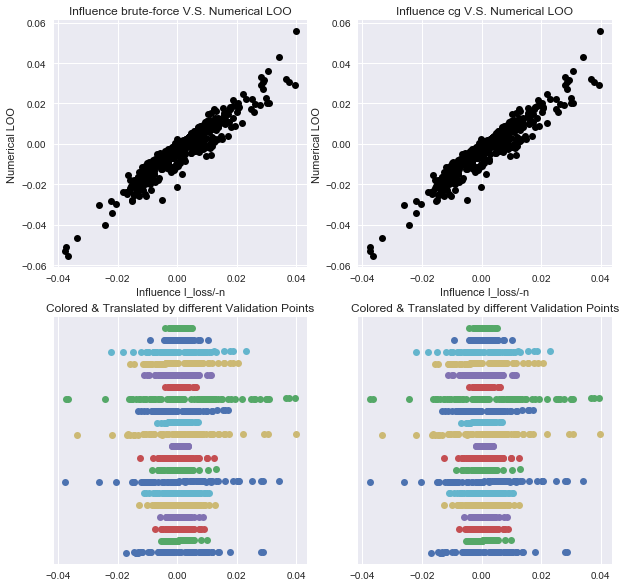

In [12]:
fig, axes = compare_with_loo(
    [I_loss_bf[:,:],
     I_loss_cg[:,:]],
    loo_diff, n_samples=n_tr
)

In [ ]:
# leave_indices case
a, b = loo_diff.shape
for j in range(n_te):
    print("Test Point %d Correlation: %.4f" % (j, np.corrcoef(
        I_loss_bf[leave_indices, j], loo_diff[:, j])[0][1]))
print("Overall Correlation: %.4f" % np.corrcoef(
        I_loss_bf[leave_indices, :].reshape(a*b,),
        loo_diff.reshape(a*b,))[0][1])

In [13]:
# without leave_indices case
a, b = loo_diff.shape
for j in range(n_te):
    print("Test Point %d Correlation: %.4f" % (j, np.corrcoef(
        I_loss_cg[:, j], loo_diff[:, j])[0][1]))
print("Overall Correlation: %.4f" % np.corrcoef(
        I_loss_cg[:, :].reshape(a*b,),
        loo_diff.reshape(a*b,))[0][1])

Test Point 0 Correlation: 0.9887
Test Point 1 Correlation: 0.9882
Test Point 2 Correlation: 0.9946
Test Point 3 Correlation: 0.9905
Test Point 4 Correlation: 0.9992
Test Point 5 Correlation: 0.9934
Test Point 6 Correlation: 0.9719
Test Point 7 Correlation: 0.9747
Test Point 8 Correlation: 0.9653
Test Point 9 Correlation: 0.9720
Test Point 10 Correlation: 0.9564
Test Point 11 Correlation: 0.9778
Test Point 12 Correlation: 0.9902
Test Point 13 Correlation: 0.9909
Test Point 14 Correlation: 0.9904
Test Point 15 Correlation: 0.9781
Test Point 16 Correlation: 0.9946
Test Point 17 Correlation: 0.9959
Test Point 18 Correlation: 0.9603
Test Point 19 Correlation: 0.9706
Overall Correlation: 0.9345


# Experiment 2-2: Binary Logistic Regression on MNIST

In [241]:
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test, test_indices = load_data(
    Datafile.BinaryMNIST17, test_config=[7])
n_tr, p = X_train.shape
n_te, _ = X_test.shape
print(n_tr, p)

'''
scl_x = StandardScaler()
scl_y = StandardScaler()
X_train = scl_x.fit_transform(X_train)
X_test = scl_x.transform(X_test)
'''


init_eta = 1e-1
batch_size = 30
train_iter = 50000
traceback_checkpoint = 45000
loo_extra_iter = 5000
decay_epochs = (10000, 20000)
checkpoint_iter = traceback_checkpoint-1
iter_to_switch_off_minibatch=35000
iter_to_switch_to_sgd=np.inf
# LOO a on random set of training indices, otherwise too slow
np.random.seed(1)
leave_indices = None

if hasattr(test_indices, '__iter__') and hasattr(leave_indices, '__iter__'):
    assert not set(test_indices) & set(leave_indices)
    print(test_indices)
    print(leave_indices)

X_train shape: (9084, 784)
y_train shape: (9084, 1)
X_test shape: (1, 784)
y_test shape: (1, 1)
9084 784


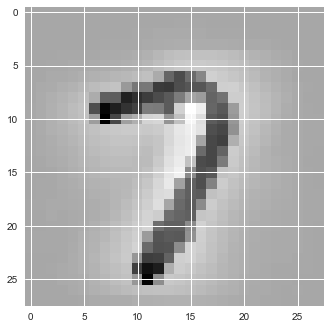

In [14]:
plt.imshow(X_test.reshape(28,28))

In [242]:
model = BinaryLogisticRegression(
    model_name='BinaryLogistic-MNIST',
    init_eta=init_eta,
    decay_epochs=decay_epochs,
    batch_size=batch_size,
    C=1e3
)

In [243]:
tf.reset_default_graph()
model.fit_with_sklearn({'X':X_train, 'y':y_train})


Model Evaluations:
------------------------------------------
Empirical Risk: 0.001630
Norm of Params: 0.108049
Norm of Gradient: 0.011894


BinaryLogistic-MNIST(init_eta=0.1,batch_size=30,decay_epochs=(10000, 20000),C=1000.0)

In [17]:
y_pred = model.predict(X_train)
print("Train accuracy:", np.sum(y_pred == y_train)/n_tr)

y_pred_test = model.predict(X_test)
print("Test accuracy:", np.sum(y_pred_test == y_test)/n_te)

Train accuracy: 0.9919638925583444
Test accuracy: 1.0


In [18]:
%%time
I_loss_bf = model.influence_loss(
    X_test, y_test,
    method='brute-force',
    damping=0.0
)

Fetch training loss gradients (4.930 sec)
CPU times: user 15.9 s, sys: 911 ms, total: 16.8 s
Wall time: 8.34 s


In [69]:
%%time
I_loss_lissa_repeat = model.influence_loss(
    X_test, y_test,
    method='lissa',
    damping=0.0,
    depth=10000,
    repeat=10,
    batch_size=1,
    verbose=100,
    scale=1e3
)

Fetch training loss gradients (5.887 sec)
--- Lissa Sample 0 ---
Recursion depth: 0, hvp norm: 0.31593021750450134
Recursion depth: 100, hvp norm: 15.708332061767578
Recursion depth: 200, hvp norm: 30.551620483398438
Recursion depth: 300, hvp norm: 44.843387603759766
Recursion depth: 400, hvp norm: 58.29053497314453
Recursion depth: 500, hvp norm: 71.0838851928711
Recursion depth: 600, hvp norm: 82.9208984375
Recursion depth: 700, hvp norm: 93.98828125
Recursion depth: 800, hvp norm: 105.46417236328125
Recursion depth: 900, hvp norm: 115.85350799560547
Recursion depth: 1000, hvp norm: 126.58280181884766
Recursion depth: 1100, hvp norm: 136.84190368652344
Recursion depth: 1200, hvp norm: 147.3836212158203
Recursion depth: 1300, hvp norm: 156.63729858398438
Recursion depth: 1400, hvp norm: 165.60598754882812
Recursion depth: 1500, hvp norm: 173.5410614013672
Recursion depth: 1600, hvp norm: 182.63365173339844
Recursion depth: 1700, hvp norm: 191.25384521484375
Recursion depth: 1800, hvp 

Recursion depth: 6200, hvp norm: 383.195068359375
Recursion depth: 6300, hvp norm: 385.8733825683594
Recursion depth: 6400, hvp norm: 385.979248046875
Recursion depth: 6500, hvp norm: 387.8570251464844
Recursion depth: 6600, hvp norm: 388.7386169433594
Recursion depth: 6700, hvp norm: 391.31182861328125
Recursion depth: 6800, hvp norm: 391.75775146484375
Recursion depth: 6900, hvp norm: 391.243896484375
Recursion depth: 7000, hvp norm: 393.1823425292969
Recursion depth: 7100, hvp norm: 395.1573791503906
Recursion depth: 7200, hvp norm: 395.2734375
Recursion depth: 7300, hvp norm: 396.78955078125
Recursion depth: 7400, hvp norm: 398.8559875488281
Recursion depth: 7500, hvp norm: 400.25421142578125
Recursion depth: 7600, hvp norm: 401.5168762207031
Recursion depth: 7700, hvp norm: 402.33966064453125
Recursion depth: 7800, hvp norm: 404.2704162597656
Recursion depth: 7900, hvp norm: 406.31011962890625
Recursion depth: 8000, hvp norm: 409.00653076171875
Recursion depth: 8100, hvp norm: 408

Recursion depth: 2400, hvp norm: 239.71395874023438
Recursion depth: 2500, hvp norm: 245.90509033203125
Recursion depth: 2600, hvp norm: 252.68544006347656
Recursion depth: 2700, hvp norm: 258.8648681640625
Recursion depth: 2800, hvp norm: 264.89215087890625
Recursion depth: 2900, hvp norm: 268.6363830566406
Recursion depth: 3000, hvp norm: 273.7191162109375
Recursion depth: 3100, hvp norm: 278.1591796875
Recursion depth: 3200, hvp norm: 283.3470153808594
Recursion depth: 3300, hvp norm: 286.30133056640625
Recursion depth: 3400, hvp norm: 291.4183654785156
Recursion depth: 3500, hvp norm: 295.4582824707031
Recursion depth: 3600, hvp norm: 299.3594055175781
Recursion depth: 3700, hvp norm: 301.16192626953125
Recursion depth: 3800, hvp norm: 304.5498352050781
Recursion depth: 3900, hvp norm: 309.7841491699219
Recursion depth: 4000, hvp norm: 313.47222900390625
Recursion depth: 4100, hvp norm: 317.218994140625
Recursion depth: 4200, hvp norm: 320.72503662109375
Recursion depth: 4300, hvp 

Recursion depth: 8500, hvp norm: 417.633056640625
Recursion depth: 8600, hvp norm: 417.2751770019531
Recursion depth: 8700, hvp norm: 418.1923828125
Recursion depth: 8800, hvp norm: 418.9202880859375
Recursion depth: 8900, hvp norm: 419.5666198730469
Recursion depth: 9000, hvp norm: 421.2684631347656
Recursion depth: 9100, hvp norm: 422.1646728515625
Recursion depth: 9200, hvp norm: 421.94049072265625
Recursion depth: 9300, hvp norm: 423.0406188964844
Recursion depth: 9400, hvp norm: 424.4193115234375
Recursion depth: 9500, hvp norm: 425.0836181640625
Recursion depth: 9600, hvp norm: 426.493408203125
Recursion depth: 9700, hvp norm: 428.6861572265625
Recursion depth: 9800, hvp norm: 430.16571044921875
Recursion depth: 9900, hvp norm: 431.1823425292969
--- Lissa Sample 5 ---
Recursion depth: 0, hvp norm: 0.3159083127975464
Recursion depth: 100, hvp norm: 15.678901672363281
Recursion depth: 200, hvp norm: 30.237220764160156
Recursion depth: 300, hvp norm: 44.24120330810547
Recursion dept

Recursion depth: 4500, hvp norm: 339.5771179199219
Recursion depth: 4600, hvp norm: 341.7233581542969
Recursion depth: 4700, hvp norm: 345.14483642578125
Recursion depth: 4800, hvp norm: 348.0704650878906
Recursion depth: 4900, hvp norm: 351.1955871582031
Recursion depth: 5000, hvp norm: 354.90716552734375
Recursion depth: 5100, hvp norm: 357.3354187011719
Recursion depth: 5200, hvp norm: 359.6927490234375
Recursion depth: 5300, hvp norm: 361.60687255859375
Recursion depth: 5400, hvp norm: 364.35498046875
Recursion depth: 5500, hvp norm: 368.1846008300781
Recursion depth: 5600, hvp norm: 370.3070373535156
Recursion depth: 5700, hvp norm: 373.051025390625
Recursion depth: 5800, hvp norm: 376.2936096191406
Recursion depth: 5900, hvp norm: 377.80609130859375
Recursion depth: 6000, hvp norm: 379.5033874511719
Recursion depth: 6100, hvp norm: 381.049072265625
Recursion depth: 6200, hvp norm: 383.6623229980469
Recursion depth: 6300, hvp norm: 385.5751647949219
Recursion depth: 6400, hvp norm

Recursion depth: 500, hvp norm: 70.43716430664062
Recursion depth: 600, hvp norm: 82.38018798828125
Recursion depth: 700, hvp norm: 94.05178833007812
Recursion depth: 800, hvp norm: 104.49636840820312
Recursion depth: 900, hvp norm: 114.66474914550781
Recursion depth: 1000, hvp norm: 125.5121841430664
Recursion depth: 1100, hvp norm: 136.05447387695312
Recursion depth: 1200, hvp norm: 146.79933166503906
Recursion depth: 1300, hvp norm: 156.9084930419922
Recursion depth: 1400, hvp norm: 165.52088928222656
Recursion depth: 1500, hvp norm: 174.53546142578125
Recursion depth: 1600, hvp norm: 182.90261840820312
Recursion depth: 1700, hvp norm: 190.69140625
Recursion depth: 1800, hvp norm: 196.82757568359375
Recursion depth: 1900, hvp norm: 204.6138916015625
Recursion depth: 2000, hvp norm: 210.90185546875
Recursion depth: 2100, hvp norm: 218.71153259277344
Recursion depth: 2200, hvp norm: 224.5641326904297
Recursion depth: 2300, hvp norm: 231.64581298828125
Recursion depth: 2400, hvp norm: 

Recursion depth: 6600, hvp norm: 390.6933898925781
Recursion depth: 6700, hvp norm: 392.5999450683594
Recursion depth: 6800, hvp norm: 394.6796569824219
Recursion depth: 6900, hvp norm: 395.6393127441406
Recursion depth: 7000, hvp norm: 396.3148498535156
Recursion depth: 7100, hvp norm: 397.893798828125
Recursion depth: 7200, hvp norm: 398.7187194824219
Recursion depth: 7300, hvp norm: 400.9776916503906
Recursion depth: 7400, hvp norm: 402.0576477050781
Recursion depth: 7500, hvp norm: 403.4715881347656
Recursion depth: 7600, hvp norm: 403.0381164550781
Recursion depth: 7700, hvp norm: 403.0826416015625
Recursion depth: 7800, hvp norm: 404.74981689453125
Recursion depth: 7900, hvp norm: 404.51385498046875
Recursion depth: 8000, hvp norm: 405.9254455566406
Recursion depth: 8100, hvp norm: 407.14739990234375
Recursion depth: 8200, hvp norm: 407.80126953125
Recursion depth: 8300, hvp norm: 410.2498779296875
Recursion depth: 8400, hvp norm: 412.3845520019531
Recursion depth: 8500, hvp norm

In [63]:
%%time
I_loss_lissa = model.influence_loss(
    X_test, y_test,
    method='lissa',
    damping=0.0,
    depth=10000,
    repeat=1,
    batch_size=1,
    verbose=100,
    scale=1e3
)

Fetch training loss gradients (4.510 sec)
--- Lissa Sample 0 ---
Recursion depth: 0, hvp norm: 0.31595417857170105
Recursion depth: 100, hvp norm: 15.78557300567627
Recursion depth: 200, hvp norm: 30.29708480834961
Recursion depth: 300, hvp norm: 43.848384857177734
Recursion depth: 400, hvp norm: 57.36093521118164
Recursion depth: 500, hvp norm: 70.18793487548828
Recursion depth: 600, hvp norm: 82.62786102294922
Recursion depth: 700, hvp norm: 94.44935607910156
Recursion depth: 800, hvp norm: 105.98516845703125
Recursion depth: 900, hvp norm: 116.96090698242188
Recursion depth: 1000, hvp norm: 127.57859802246094
Recursion depth: 1100, hvp norm: 137.8304443359375
Recursion depth: 1200, hvp norm: 147.09542846679688
Recursion depth: 1300, hvp norm: 155.6376495361328
Recursion depth: 1400, hvp norm: 164.69210815429688
Recursion depth: 1500, hvp norm: 173.6093292236328
Recursion depth: 1600, hvp norm: 182.222900390625
Recursion depth: 1700, hvp norm: 190.25634765625
Recursion depth: 1800, h

In [59]:
%%time
I_loss_cg = model.influence_loss(
    X_test, y_test,
    method='cg',
    tol=1e-7, 
    max_iter=1000,
    damping=0.0
)
# I_loss_bf[leave_indices,:]/n_tr

Fetch training loss gradients (6.033 sec)
CG Objective: -0.03189686
CG Objective: -0.032787364
CG Objective: -0.03284464
CG Objective: -0.03284954
CG Objective: -0.032849584
         Current function value: -0.032850
         Iterations: 5
         Function evaluations: 73
         Gradient evaluations: 66
         Hessian evaluations: 18
CPU times: user 11.5 s, sys: 1.83 s, total: 13.3 s
Wall time: 10.1 s


In [19]:
loo_diff = model.leave_one_out_refit(
    X_test, y_test,
    n_iter=loo_extra_iter,
    iter_to_load=checkpoint_iter,
    leave_indices=leave_indices,
    sklearn_refit=True,
    verbose=0.001
)

LOO Fold 0: loss = 0.09969970 (0.083 sec)
LOO Fold 9: loss = 0.09969810 (0.123 sec)
LOO Fold 18: loss = 0.09963135 (0.149 sec)
LOO Fold 27: loss = 0.09969766 (0.098 sec)
LOO Fold 36: loss = 0.09969550 (0.105 sec)
LOO Fold 45: loss = 0.09969808 (0.106 sec)
LOO Fold 54: loss = 0.09969677 (0.110 sec)
LOO Fold 63: loss = 0.09969270 (0.115 sec)
LOO Fold 72: loss = 0.09969535 (0.088 sec)
LOO Fold 81: loss = 0.09968258 (0.146 sec)
LOO Fold 90: loss = 0.09969901 (0.092 sec)
LOO Fold 99: loss = 0.09969845 (0.114 sec)
LOO Fold 108: loss = 0.09966832 (0.142 sec)
LOO Fold 117: loss = 0.09969383 (0.129 sec)
LOO Fold 126: loss = 0.09969684 (0.112 sec)
LOO Fold 135: loss = 0.09969720 (0.111 sec)
LOO Fold 144: loss = 0.09969946 (0.121 sec)
LOO Fold 153: loss = 0.09969686 (0.095 sec)
LOO Fold 162: loss = 0.09969834 (0.140 sec)
LOO Fold 171: loss = 0.09969867 (0.092 sec)
LOO Fold 180: loss = 0.09969839 (0.099 sec)
LOO Fold 189: loss = 0.09969913 (0.124 sec)
LOO Fold 198: loss = 0.09969750 (0.111 sec)
LO

LOO Fold 1665: loss = 0.09969627 (0.233 sec)
LOO Fold 1674: loss = 0.09969831 (0.148 sec)
LOO Fold 1683: loss = 0.09968305 (0.118 sec)
LOO Fold 1692: loss = 0.09969874 (0.185 sec)
LOO Fold 1701: loss = 0.09969775 (0.146 sec)
LOO Fold 1710: loss = 0.09969944 (0.331 sec)
LOO Fold 1719: loss = 0.09969703 (0.151 sec)
LOO Fold 1728: loss = 0.09969759 (0.099 sec)
LOO Fold 1737: loss = 0.09969872 (0.210 sec)
LOO Fold 1746: loss = 0.09969860 (0.203 sec)
LOO Fold 1755: loss = 0.09960517 (0.306 sec)
LOO Fold 1764: loss = 0.09969915 (0.185 sec)
LOO Fold 1773: loss = 0.09969936 (0.106 sec)
LOO Fold 1782: loss = 0.09959946 (0.271 sec)
LOO Fold 1791: loss = 0.09969944 (0.116 sec)
LOO Fold 1800: loss = 0.09968609 (0.195 sec)
LOO Fold 1809: loss = 0.09969835 (0.108 sec)
LOO Fold 1818: loss = 0.09969805 (0.201 sec)
LOO Fold 1827: loss = 0.09969795 (0.125 sec)
LOO Fold 1836: loss = 0.09969682 (0.154 sec)
LOO Fold 1845: loss = 0.09969871 (0.073 sec)
LOO Fold 1854: loss = 0.09969816 (0.145 sec)
LOO Fold 1

LOO Fold 3312: loss = 0.09969880 (0.082 sec)
LOO Fold 3321: loss = 0.09969912 (0.072 sec)
LOO Fold 3330: loss = 0.09969740 (0.130 sec)
LOO Fold 3339: loss = 0.09969771 (0.092 sec)
LOO Fold 3348: loss = 0.09969651 (0.116 sec)
LOO Fold 3357: loss = 0.09969394 (0.096 sec)
LOO Fold 3366: loss = 0.09969867 (0.087 sec)
LOO Fold 3375: loss = 0.09969271 (0.094 sec)
LOO Fold 3384: loss = 0.09969846 (0.072 sec)
LOO Fold 3393: loss = 0.09969816 (0.086 sec)
LOO Fold 3402: loss = 0.09967059 (0.123 sec)
LOO Fold 3411: loss = 0.09969893 (0.066 sec)
LOO Fold 3420: loss = 0.09969942 (0.084 sec)
LOO Fold 3429: loss = 0.09969706 (0.087 sec)
LOO Fold 3438: loss = 0.09969589 (0.093 sec)
LOO Fold 3447: loss = 0.09969921 (0.090 sec)
LOO Fold 3456: loss = 0.09969838 (0.083 sec)
LOO Fold 3465: loss = 0.09969840 (0.081 sec)
LOO Fold 3474: loss = 0.09969867 (0.097 sec)
LOO Fold 3483: loss = 0.09969866 (0.076 sec)
LOO Fold 3492: loss = 0.09969912 (0.133 sec)
LOO Fold 3501: loss = 0.09969771 (0.079 sec)
LOO Fold 3

LOO Fold 4959: loss = 0.09969647 (0.097 sec)
LOO Fold 4968: loss = 0.09969769 (0.087 sec)
LOO Fold 4977: loss = 0.09969552 (0.097 sec)
LOO Fold 4986: loss = 0.09969853 (0.107 sec)
LOO Fold 4995: loss = 0.09969920 (0.094 sec)
LOO Fold 5004: loss = 0.09966866 (0.120 sec)
LOO Fold 5013: loss = 0.09969003 (0.140 sec)
LOO Fold 5022: loss = 0.09969871 (0.068 sec)
LOO Fold 5031: loss = 0.09969895 (0.121 sec)
LOO Fold 5040: loss = 0.09969950 (0.132 sec)
LOO Fold 5049: loss = 0.09964100 (0.145 sec)
LOO Fold 5058: loss = 0.09969803 (0.091 sec)
LOO Fold 5067: loss = 0.09969643 (0.133 sec)
LOO Fold 5076: loss = 0.09968637 (0.124 sec)
LOO Fold 5085: loss = 0.09969804 (0.078 sec)
LOO Fold 5094: loss = 0.09969810 (0.083 sec)
LOO Fold 5103: loss = 0.09969829 (0.095 sec)
LOO Fold 5112: loss = 0.09969549 (0.117 sec)
LOO Fold 5121: loss = 0.09969724 (0.066 sec)
LOO Fold 5130: loss = 0.09968664 (0.112 sec)
LOO Fold 5139: loss = 0.09969757 (0.106 sec)
LOO Fold 5148: loss = 0.09968910 (0.110 sec)
LOO Fold 5

LOO Fold 6606: loss = 0.09969641 (0.142 sec)
LOO Fold 6615: loss = 0.09968746 (0.119 sec)
LOO Fold 6624: loss = 0.09968957 (0.098 sec)
LOO Fold 6633: loss = 0.09969398 (0.108 sec)
LOO Fold 6642: loss = 0.09969938 (0.067 sec)
LOO Fold 6651: loss = 0.09969839 (0.069 sec)
LOO Fold 6660: loss = 0.09969883 (0.070 sec)
LOO Fold 6669: loss = 0.09969609 (0.100 sec)
LOO Fold 6678: loss = 0.09969838 (0.092 sec)
LOO Fold 6687: loss = 0.09969941 (0.088 sec)
LOO Fold 6696: loss = 0.09969833 (0.067 sec)
LOO Fold 6705: loss = 0.09969511 (0.096 sec)
LOO Fold 6714: loss = 0.09969920 (0.111 sec)
LOO Fold 6723: loss = 0.09969795 (0.070 sec)
LOO Fold 6732: loss = 0.09967165 (0.125 sec)
LOO Fold 6741: loss = 0.09969646 (0.089 sec)
LOO Fold 6750: loss = 0.09969568 (0.125 sec)
LOO Fold 6759: loss = 0.09969796 (0.087 sec)
LOO Fold 6768: loss = 0.09969880 (0.105 sec)
LOO Fold 6777: loss = 0.09969649 (0.096 sec)
LOO Fold 6786: loss = 0.09969095 (0.102 sec)
LOO Fold 6795: loss = 0.09969918 (0.104 sec)
LOO Fold 6

LOO Fold 8253: loss = 0.09969561 (0.093 sec)
LOO Fold 8262: loss = 0.09969837 (0.110 sec)
LOO Fold 8271: loss = 0.09969221 (0.100 sec)
LOO Fold 8280: loss = 0.09969804 (0.091 sec)
LOO Fold 8289: loss = 0.09967261 (0.110 sec)
LOO Fold 8298: loss = 0.09969917 (0.067 sec)
LOO Fold 8307: loss = 0.09969743 (0.089 sec)
LOO Fold 8316: loss = 0.09969725 (0.081 sec)
LOO Fold 8325: loss = 0.09969803 (0.066 sec)
LOO Fold 8334: loss = 0.09969124 (0.095 sec)
LOO Fold 8343: loss = 0.09969907 (0.078 sec)
LOO Fold 8352: loss = 0.09969688 (0.094 sec)
LOO Fold 8361: loss = 0.09969917 (0.065 sec)
LOO Fold 8370: loss = 0.09969690 (0.073 sec)
LOO Fold 8379: loss = 0.09969664 (0.099 sec)
LOO Fold 8388: loss = 0.09969606 (0.090 sec)
LOO Fold 8397: loss = 0.09968857 (0.195 sec)
LOO Fold 8406: loss = 0.09969679 (0.172 sec)
LOO Fold 8415: loss = 0.09967732 (0.254 sec)
LOO Fold 8424: loss = 0.09969512 (0.292 sec)
LOO Fold 8433: loss = 0.09969822 (0.160 sec)
LOO Fold 8442: loss = 0.09969925 (0.067 sec)
LOO Fold 8

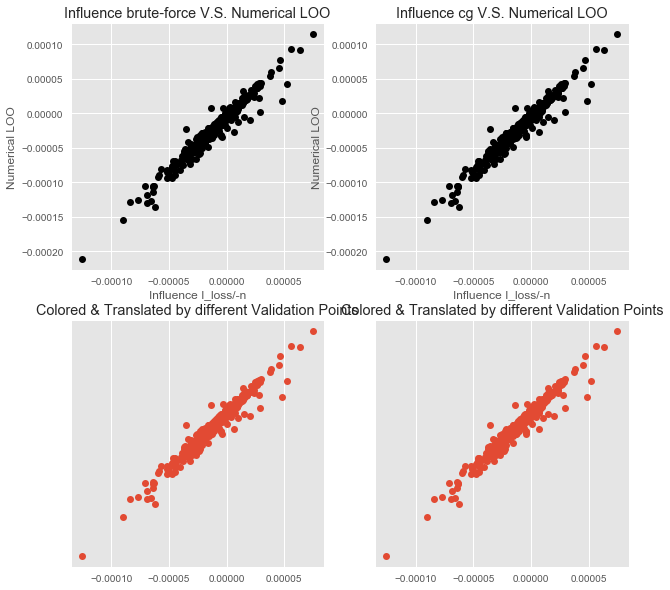

In [21]:
plt.style.use('ggplot')
fig, axes = compare_with_loo(
    [I_loss_bf[:,:],
     I_loss_bf[:,:]],
    loo_diff, n_samples=n_tr
)

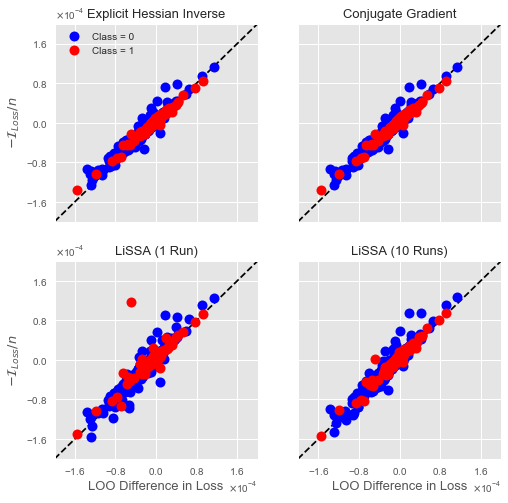

In [151]:
from matplotlib import ticker
frame_trunc = 0.0002
fig, axes = plt.subplots(
    2, 2, figsize=(8, 8), sharex='all', sharey='all')
# frame_trunc = np.percentile(loo_diff, trunc)
axes = axes.reshape(4,)
fontsize = 13
axes[0].plot(
    [-frame_trunc, frame_trunc],
    [-frame_trunc,frame_trunc], '--', color='black'
)
axes[0].plot(
    loo_diff[:, :][y_train==0], 
    1.5*I_loss_bf[:, :][y_train==0] / n_tr, 
    'o', markersize=10, color='blue', label='Class = 0'
)
axes[0].plot(
    loo_diff[:, :][y_train==1], 
    1.5*I_loss_bf[:, :][y_train==1] / n_tr, 
    'o', markersize=10, color='red', label='Class = 1'
)
axes[1].plot(
    [-frame_trunc, frame_trunc],
    [-frame_trunc,frame_trunc], '--', color='black'
)
axes[1].plot(
    loo_diff[:, :][y_train==0], 
    1.5*I_loss_cg[:, :][y_train==0] / n_tr, 
    'o', markersize=10, color='blue'
)
axes[1].plot(
    loo_diff[:, :][y_train==1], 
    1.5*I_loss_cg[:, :][y_train==1] / n_tr, 
    'o', markersize=10, color='red'
)
axes[2].plot(
    [-frame_trunc, frame_trunc],
    [-frame_trunc,frame_trunc], '--', color='black'
)
axes[2].plot(
    loo_diff[:, :][y_train==0], 
    1.8*I_loss_lissa[:, :][y_train==0] / n_tr, 
    'o', markersize=10, color='blue'
)
axes[2].plot(
    loo_diff[:, :][y_train==1], 
    1.8*I_loss_lissa[:, :][y_train==1] / n_tr, 
    'o', markersize=10, color='red'
)
axes[3].plot(
    [-frame_trunc, frame_trunc],
    [-frame_trunc,frame_trunc], '--', color='black'
)
axes[3].plot(
    loo_diff[:, :][y_train==0], 
    1.8*I_loss_lissa_repeat[:, :][y_train==0] / n_tr, 
    'o', markersize=10, color='blue',label='class=0'
)
axes[3].plot(
    loo_diff[:, :][y_train==1], 
    1.8*I_loss_lissa_repeat[:, :][y_train==1] / n_tr, 
    'o', markersize=10, color='red', label='class=1'
)
"""
axes[1].plot(
    [-frame_trunc, frame_trunc],
    [-frame_trunc, frame_trunc], '--', color='black'
)
axes[1].plot(
    loo_diff[:, :],
    I_loss_cg[:, :] / n_tr, 'o', markersize=10
)
axes[2].plot(
    [-frame_trunc, frame_trunc],
    [-frame_trunc,frame_trunc], '--', color='black'
)
axes[2].plot(
    loo_diff[:, :], 
    I_loss_lissa_deep[:, :] / n_tr, 'o', markersize=10
)
axes[3].plot(
    [-frame_trunc, frame_trunc],
    [-frame_trunc,frame_trunc], '--', color='black'
)
axes[3].plot(
    loo_diff[:, :], 
    I_loss_lissa_shallow[:, :] / n_tr, 'o', markersize=10
)
"""
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((0,0))


axes[0].xaxis.set_major_formatter(formatter)
axes[0].yaxis.set_major_formatter(formatter)
axes[0].ticklabel_format(rotation=14,
    style='sci', axis='x', scilimits=(-2,2))
axes[0].ticklabel_format(style='sci', axis='y', scilimits=(-2,2))

#plt.ticklabel_format(style='sci',scilimits=(-3,4),axis='x')

axes[0].update({
    'title': 'Influence 1 V.S. Numerical LOO',
    'ylabel': 'Numerical LOO',
    'xlim': (-frame_trunc, frame_trunc),
    'ylim': (-frame_trunc, frame_trunc),
    'xticks':[-0.00016, -0.00008, 0, 0.00008, 0.00016],
    'yticks':[-0.00016, -0.00008, 0, 0.00008, 0.00016],
})
axes[1].set_xlim((-frame_trunc, frame_trunc))
axes[2].set_xlim((-frame_trunc, frame_trunc))
#axes[1].set_xticks([-150, -75, 0, 75, 150])
#axes[2].set_xticks([-150, -75, 0, 75, 150])
#axes[0].set_xlabel('LOO Difference in Loss', fontsize=fontsize)
#axes[1].set_xlabel('LOO Difference in Loss', fontsize=fontsize)
axes[2].set_xlabel('LOO Difference in Loss', fontsize=fontsize)
axes[3].set_xlabel('LOO Difference in Loss', fontsize=fontsize)
axes[0].set_ylabel(r'$-\mathcal{I}_{Loss} / n$', fontsize=fontsize)
axes[2].set_ylabel(r'$-\mathcal{I}_{Loss} / n$', fontsize=fontsize)
axes[0].set_title('Explicit Hessian Inverse', fontsize=fontsize)
axes[1].set_title('Conjugate Gradient', fontsize=fontsize)
axes[2].set_title(r'LiSSA (1 Run)', fontsize=fontsize)
axes[3].set_title('LiSSA (10 Runs)', fontsize=fontsize)
#axes[0].set_xticklabels([-0.00016, -0.00008, 0, 0.00008, 0.00016], rotation=15)
#axes[2].imshow(X_test.reshape((28,28)))
axes[0].legend()

plt.savefig('tex/report/fig-logit.eps', dpi=600, bbox_inches='tight')

array([[ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.0

In [244]:
beta = model.get_eval(items=['params'])['beta']
sigm = lambda t: 1/(1+np.exp(-t))
H = 0
for i in range(n_tr):
    xi = X_train[i,:].reshape((1,784))
    H += sigm(xi.dot(beta))* sigm(-xi.dot(beta))*xi.T.dot(xi)/n_tr
    if i % 100 == 0:
        print(i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000


In [245]:
H_inv = np.linalg.inv(H+0.001*np.eye(784))

In [235]:
X_train = scl_x.inverse_transform(X_train)
X_test = scl_x.inverse_transform(X_test)

In [250]:
lte

array([[3.0893479e-13]])

In [246]:
y_sgn = np.copy(y_train)
lte = (sigm(beta.T.dot(X_test.T)) - y_test)
ltr = (sigm(X_train.dot(beta)) - y_train)
I_logit_naive = X_train.dot(X_test.T)*lte
I_logit_woH = X_train.dot(X_test.T)*lte*ltr
I_logit_scaled_ip = X_train.dot(H_inv).dot(X_test.T)*lte
I_logit_full = I_logit_scaled_ip*ltr

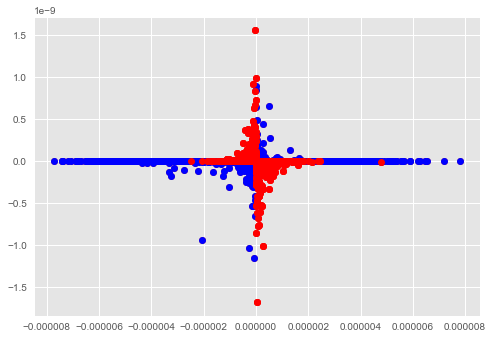

In [247]:
plt.plot(-I_logit_scaled_ip, -I_logit_full, 'o')
plt.plot(-I_logit_scaled_ip[y_train==1], 
         -I_logit_full[y_train==1], 'o',
        color='red')
plt.plot(-I_logit_scaled_ip[y_train==0], 
         -I_logit_full[y_train==0], 'o',
        color='blue')
plt.plot(-I_logit_scaled_ip[y_train==1], 
         -I_logit_full[y_train==1], 'o',
        color='red')

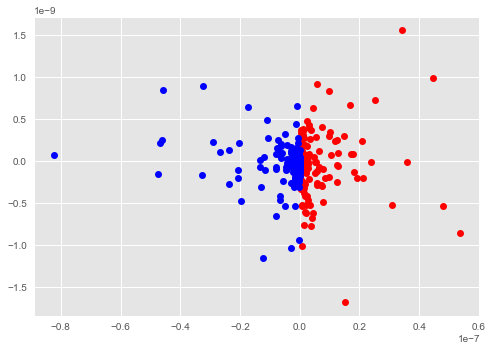

In [248]:
plt.plot(-I_logit_woH[y_train==1], 
         -I_logit_full[y_train==1], 'o',
        color='red')
plt.plot(-I_logit_woH[y_train==0], 
         -I_logit_full[y_train==0], 'o',
        color='blue')

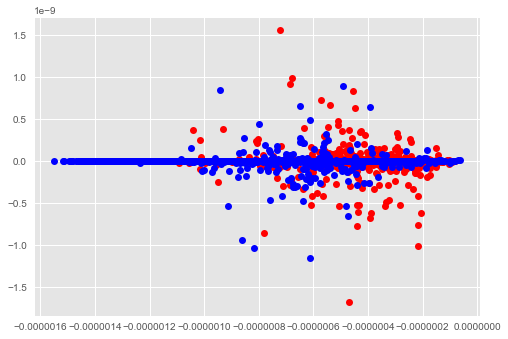

In [249]:
plt.plot(-I_logit_naive[y_train==1], 
         -I_logit_full[y_train==1], 'o',
        color='red')
plt.plot(-I_logit_naive[y_train==0], 
         -I_logit_full[y_train==0], 'o',
        color='blue')

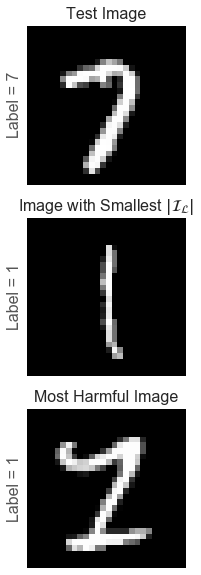

In [161]:
# 7 = 0
fig, axes = plt.subplots(
    3, 1, figsize=(4, 13))
# frame_trunc = np.percentile(loo_diff, trunc)
axes = axes.reshape(3,)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[2].set_xticks([])
axes[2].set_yticks([])
axes[0].imshow(scl_x.inverse_transform(X_test).reshape(28,28),
              cmap=plt.get_cmap('gray'))
axes[0].set_title('Test Image',fontsize=16)
axes[0].set_ylabel('Label = 7',fontsize=16)
axes[1].set_title(r'Image with Smallest $|\mathcal{I}_{\mathcal{L}}|$',fontsize=16)
axes[1].set_ylabel('Label = 1', fontsize=16)
axes[2].set_title('Most Harmful Image',fontsize=16)
axes[2].set_ylabel('Label = 1',fontsize=16)
#axes[2].set_xlabel('Image Instances',fontsize=18)

axes[1].imshow(scl_x.inverse_transform(
    X_train[5989,:]).reshape(28,28),
               cmap=plt.get_cmap('gray'))
axes[2].imshow(scl_x.inverse_transform(X_train[np.argmin(I_loss_cg),:]).reshape(28,28),
              cmap=plt.get_cmap('gray'))
fig.subplots_adjust(bottom=0.3) # or whatever
plt.savefig('tex/report/fig-logit-img.eps', dpi=100, bbox_inches='tight')

In [ ]:
# 终于特么做出来了

In [52]:
# leave_indices case
a, b = loo_diff.shape
for j in range(n_te):
    print("Test Point %d Correlation: %.4f" % (j, np.corrcoef(
        I_loss_bf[leave_indices, j], loo_diff[:, j])[0][1]))
print("Overall Correlation: %.4f" % np.corrcoef(
        I_loss_bf[leave_indices, :].reshape(a*b,),
        loo_diff.reshape(a*b,))[0][1])

Test Point 0 Correlation: 0.9657
Test Point 1 Correlation: 0.9786
Test Point 2 Correlation: 0.9883
Test Point 3 Correlation: 0.9729
Test Point 4 Correlation: 0.9820
Test Point 5 Correlation: 0.9752
Test Point 6 Correlation: 0.9755
Test Point 7 Correlation: 0.9651
Test Point 8 Correlation: 0.9817
Test Point 9 Correlation: 0.9822
Overall Correlation: 0.9673


# Experiment 2.3: Multiclass Logistic Regression

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from sklearn.linear_model import LogisticRegression

from data import Datafile, load_data
from influence.emp_risk_optimizer import EmpiricalRiskOptimizer
from influence.plot_utils import compare_with_loo
from influence.closed_forms import I_loss_RidgeCf
from models.regularized_regression import RegularizedRegression
from models.hyperplane_clf import MulticlassLogisticRegression

In [12]:
X_train, X_test, y_train, y_test, test_indices = load_data(
    Datafile.FullMNIST, test_config=[42])
n_tr, p = X_train.shape
n_te, _ = X_test.shape

X_train shape: (41999, 784)
y_train shape: (41999, 1)
X_test shape: (1, 784)
y_test shape: (1, 1)


In [55]:
subsample = np.random.choice(n_tr, size=5000, replace=False)
X_train = X_train[subsample,:]
y_train = y_train[subsample,:]
y_train_onehot = np.eye(10)[y_train.reshape(-1)]
y_test_onehot = np.eye(10)[y_test.reshape(-1)]
n_tr, p = X_train.shape
n_te, _ = X_test.shape
print("Subsample X shape:", X_train.shape)
print("Subsample y shape:", y_train_onehot.shape)

Subsample X shape: (5000, 784)
Subsample y shape: (5000, 10)


In [56]:
init_eta = 1e-1
batch_size = 30
train_iter = 50000
traceback_checkpoint = 45000
loo_extra_iter = 5000
decay_epochs = (10000, 20000)
checkpoint_iter = traceback_checkpoint-1
iter_to_switch_off_minibatch=35000
iter_to_switch_to_sgd=np.inf
# LOO a on random set of training indices, otherwise too slow
leave_indices = np.random.choice(n_tr, size=150, replace=False)

if hasattr(test_indices, '__iter__') and hasattr(leave_indices, '__iter__'):
    assert not set(test_indices) & set(leave_indices)
    print(test_indices)
    print(leave_indices)

## Fitting

In [57]:
model = MulticlassLogisticRegression(
    model_name='MultiClassLogistic-MNIST',
    init_eta=init_eta,
    decay_epochs=decay_epochs,
    batch_size=batch_size,
    C=1e9
)

In [58]:
tf.reset_default_graph()
model.fit_with_sklearn({'X':X_train, 'y':y_train_onehot})


Model Evaluations:
------------------------------------------
Empirical Risk: 3.673785
Norm of Params: 0.002876
Norm of Gradient: 1080.059448


MultiClassLogistic-MNIST(init_eta=0.1,batch_size=30,decay_epochs=(10000, 20000),C=1000000000.0)

In [9]:
model.predict(X_train)

array([7, 6, 1, ..., 2, 8, 1])

In [59]:
print("Train accuracy:", np.sum(
    model.predict(X_train).reshape(n_tr,1) == y_train)/n_tr)
print("Test accuracy:", np.sum(
    model.predict(X_test).reshape(n_te,1) == y_test)/n_te)

Train accuracy: 0.748
Test accuracy: 0.8


In [ ]:
I_loss_bf = model.influence_loss(
    X_test, y_test_onehot,
    method='brute-force',
    damping=0.1
)
I_loss_bf

Fetch training loss gradients (4.631 sec)


In [12]:
loo_diff = model.leave_one_out_refit(
    X_test, y_test_onehot,
    n_iter=loo_extra_iter,
    iter_to_load=checkpoint_iter,
    leave_indices=leave_indices,
    sklearn_refit=True
)

LOO Fold 0: loss = 1.26281118 (0.481 sec)
LOO Fold 15: loss = 1.26280773 (0.559 sec)
LOO Fold 30: loss = 1.26287746 (0.536 sec)
LOO Fold 45: loss = 1.26292515 (0.383 sec)
LOO Fold 60: loss = 1.26283002 (0.615 sec)
LOO Fold 75: loss = 1.26289392 (0.495 sec)
LOO Fold 90: loss = 1.26281571 (0.486 sec)
LOO Fold 105: loss = 1.26286960 (0.513 sec)
LOO Fold 120: loss = 1.26285291 (0.763 sec)
LOO Fold 135: loss = 1.26283276 (0.738 sec)


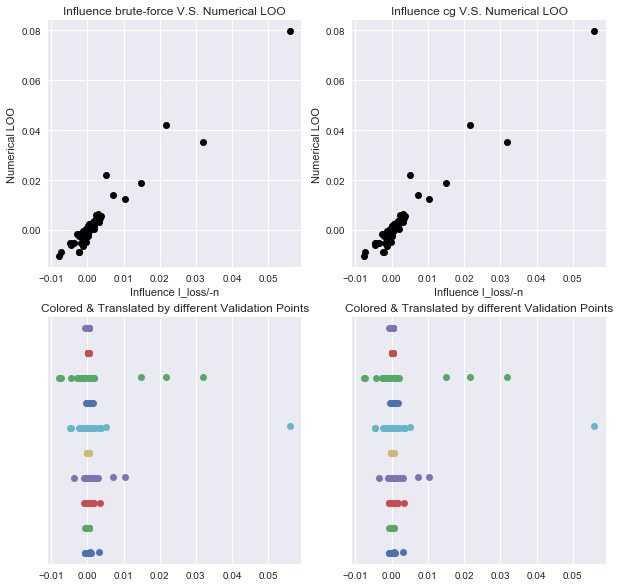

In [13]:
fig, axes = compare_with_loo(
    [I_loss_bf[leave_indices,:],
     I_loss_bf[leave_indices,:]],
    loo_diff, n_samples=n_tr
)

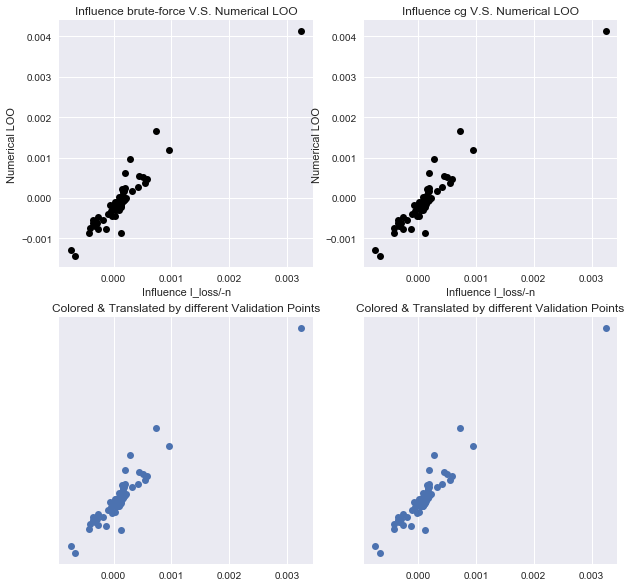

In [27]:
fig, axes = compare_with_loo(
    [I_loss_bf[leave_indices,0:1],
     I_loss_bf[leave_indices,0:1]],
    loo_diff, n_samples=n_tr
)

In [23]:
a, b = loo_diff.shape
for j in range(n_te):
    print("Test Point %d Correlation: %.4f" % (j, np.corrcoef(
        I_loss_bf[leave_indices, j], loo_diff[:, j])[0][1]))
print("Overall Correlation: %.4f" % np.corrcoef(
        I_loss_bf[leave_indices, :].reshape(a*b,),
        loo_diff.reshape(a*b,))[0][1])

Test Point 0 Correlation: 0.9460
Test Point 1 Correlation: 0.8342
Test Point 2 Correlation: 0.9240
Test Point 3 Correlation: 0.9572
Test Point 4 Correlation: 0.8526
Test Point 5 Correlation: 0.9760
Test Point 6 Correlation: 0.9342
Test Point 7 Correlation: 0.9567
Test Point 8 Correlation: 0.7819
Test Point 9 Correlation: 0.8461
Overall Correlation: 0.9676


In [11]:
lr = LogisticRegression(
    C=1/1000,
    fit_intercept=False,
    tol=1e-8,
    solver='lbfgs',
    warm_start=True,
    max_iter=1000
)
lr.fit(
    X_train,
    # feed_dict['y'] is one-hot encoded
    np.argmax(y_train_onehot, axis=1),
)

LogisticRegression(C=0.001, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=1000,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=1e-08, verbose=0, warm_start=True)

In [16]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

np.argmax(softmax(X_train.dot(lr.coef_.T)),axis=1)

array([9, 3, 4, ..., 4, 6, 3])